Este projeto tem como objetivo analisar os microdados do ENEM 2021, aplicando técnicas de análise exploratória e aprendizado de máquina para identificar padrões nos desempenhos dos candidatos. Além disso, foi realizada uma redução de dimensionalidade com PCA e testes com modelos preditivos.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

Os microdados do ENEM 2021 foram carregados a partir de um arquivo CSV de grande porte. Para otimizar a leitura e processamento, utilizamos a biblioteca Pandas e especificamos as colunas de interesse.

In [14]:
# Carregar os dados
df = pd.read_csv(r"C:\Users\kevel\OneDrive\Área de Trabalho\Data Scyentist\PROJETO DE DS\ENEM 2021\DADOS\MICRODADOS_ENEM_2021.csv",
                 sep=";", encoding='latin1')

Foram identificados e tratados valores ausentes nas colunas de interesse. Estratégias como preenchimento com valores médios ou remoção de linhas específicas foram adotadas conforme a relevância dos dados.

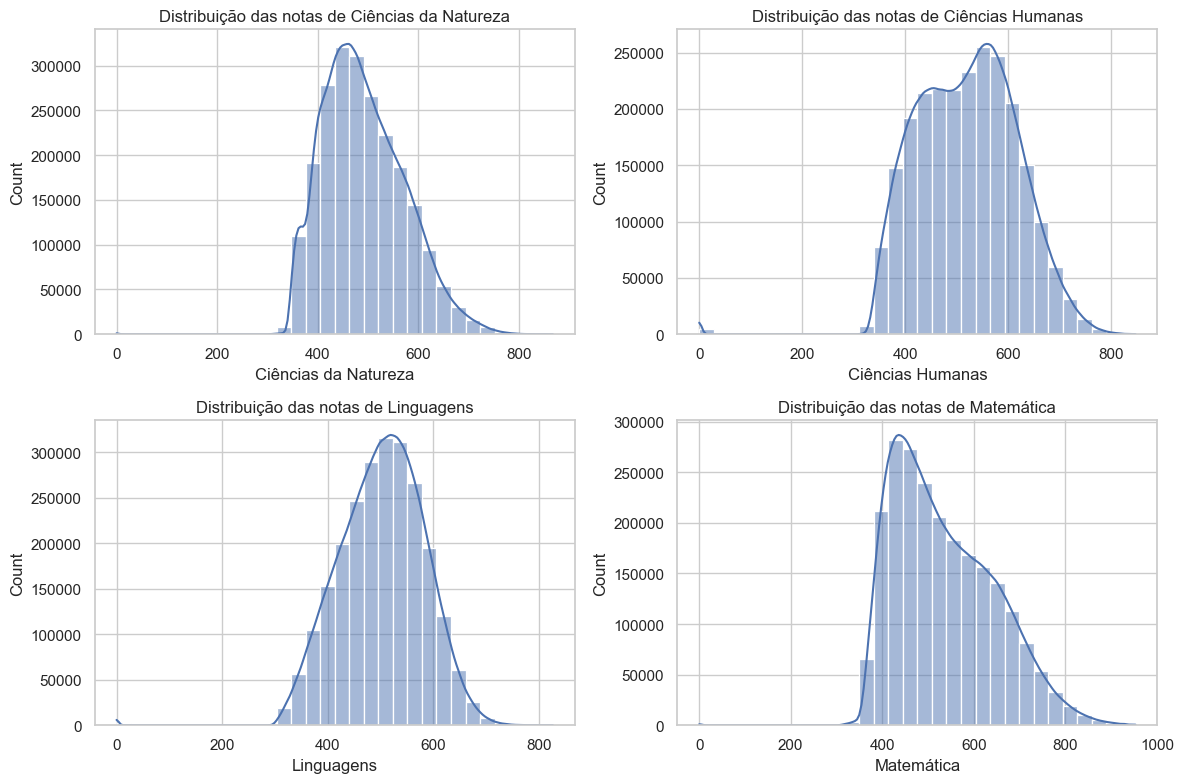

In [15]:
# Renomeando colunas para facilitar a leitura
df.rename(columns={
    'NU_NOTA_CN': 'Ciências da Natureza',
    'NU_NOTA_CH': 'Ciências Humanas',
    'NU_NOTA_LC': 'Linguagens',
    'NU_NOTA_MT': 'Matemática',
    'Q006': 'Renda Familiar',
    'TP_ESCOLA': 'Tipo de Escola',
    'SG_UF_PROVA': 'UF'
}, inplace=True)

# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

# Criando histogramas para visualizar a distribuição das notas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
notas = ['Ciências da Natureza', 'Ciências Humanas', 'Linguagens', 'Matemática']

for i, ax in enumerate(axes.flatten()):
    sns.histplot(df[notas[i]].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribuição das notas de {notas[i]}')

plt.tight_layout()
plt.show()

As notas 0 podem representar candidatos que não realizaram a prova, e não necessariamente um desempenho nulo. Isso evita distorções nas análises estatísticas.

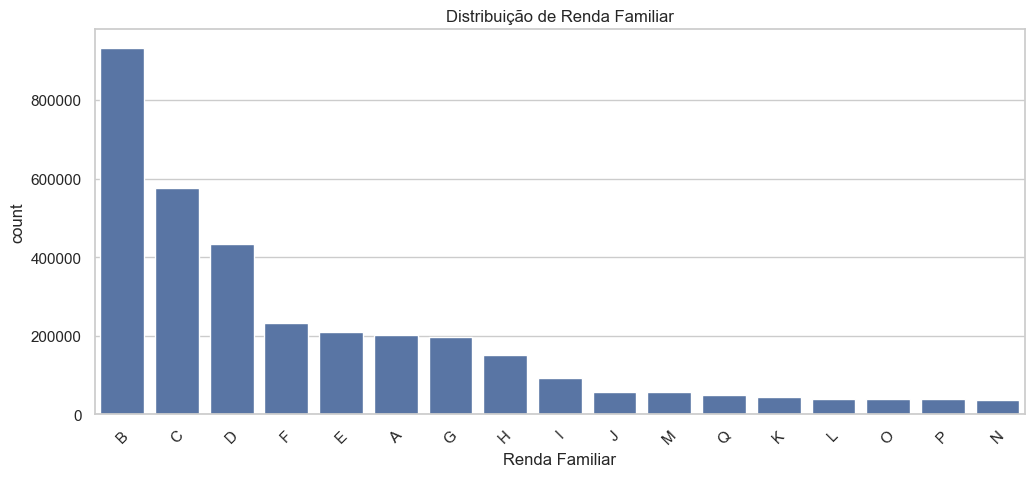

In [ ]:
# Substituindo valores 0 por NaN
df[notas] = df[notas].replace(0, np.nan)

# Distribuição de renda familiar
plt.figure(figsize=(12, 5))
sns.countplot(x='Renda Familiar', data=df, order=df['Renda Familiar'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribuição de Renda Familiar')
plt.show()

Variáveis categóricas foram transformadas em numéricas utilizando técnicas como one-hot encoding e label encoding, possibilitando sua utilização em modelos estatísticos e de machine learning.

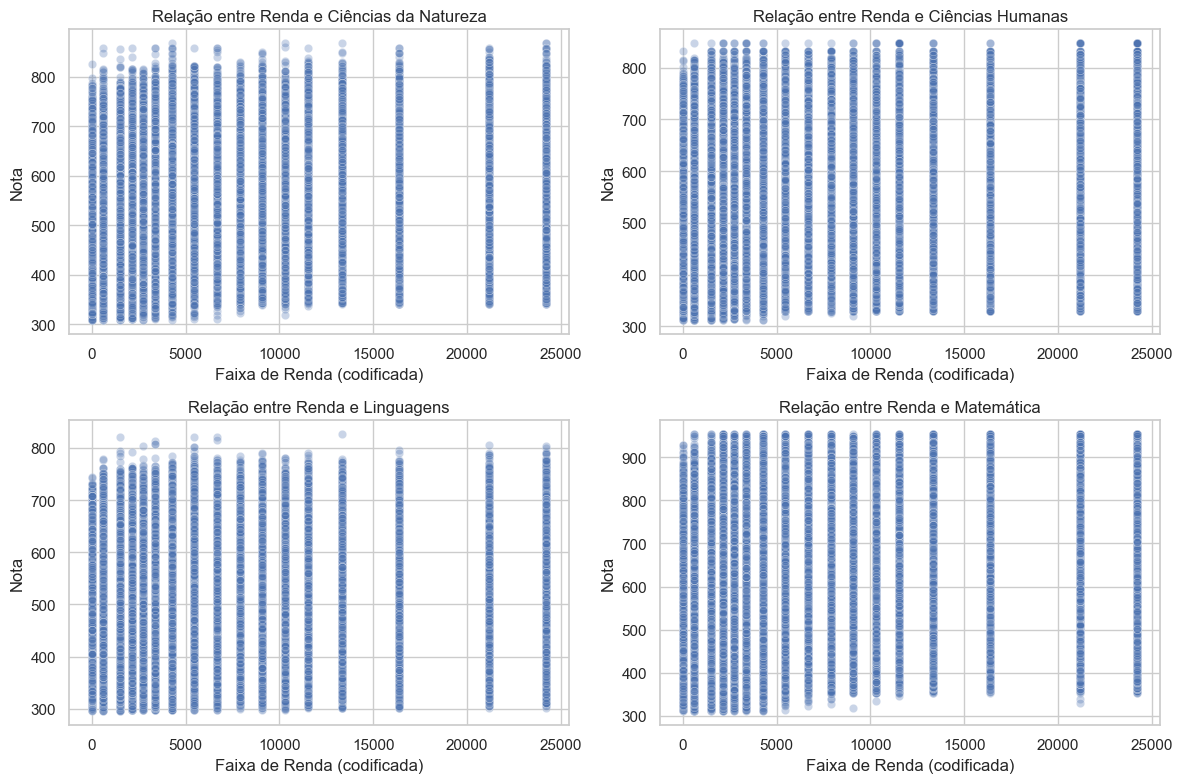

In [17]:
# Conversão da renda familiar para valores médios
# Justificativa: Transformar categorias em valores médios permite análises quantitativas mais precisas.
renda_map = {
    'A': 0, 'B': 606, 'C': 1515, 'D': 2121, 'E': 2727, 'F': 3333, 'G': 4242, 'H': 5454, 'I': 6666, 
    'J': 7878, 'K': 9090, 'L': 10302, 'M': 11514, 'N': 13332, 'O': 16362, 'P': 21210, 'Q': 24240
}
df['Renda Numérica'] = df['Renda Familiar'].map(renda_map)

# Gráficos de dispersão entre renda e notas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(x=df['Renda Numérica'], y=df[notas[i]], alpha=0.3, ax=ax)
    ax.set_title(f'Relação entre Renda e {notas[i]}')
    ax.set_xlabel('Faixa de Renda (codificada)')
    ax.set_ylabel('Nota')

plt.tight_layout()
plt.show()

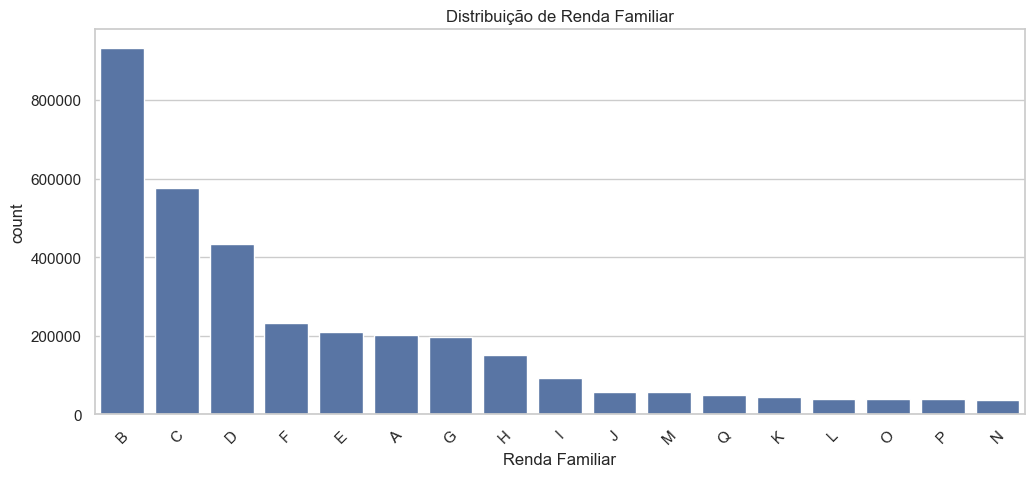

In [18]:
# Substituindo valores 0 por NaN
# Justificativa: As notas 0 podem representar candidatos que não realizaram a prova, 
# e não necessariamente um desempenho nulo. Isso evita distorções nas análises estatísticas.
df[notas] = df[notas].replace(0, np.nan)

# Distribuição de renda familiar
plt.figure(figsize=(12, 5))
sns.countplot(x='Renda Familiar', data=df, order=df['Renda Familiar'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribuição de Renda Familiar')
plt.show()

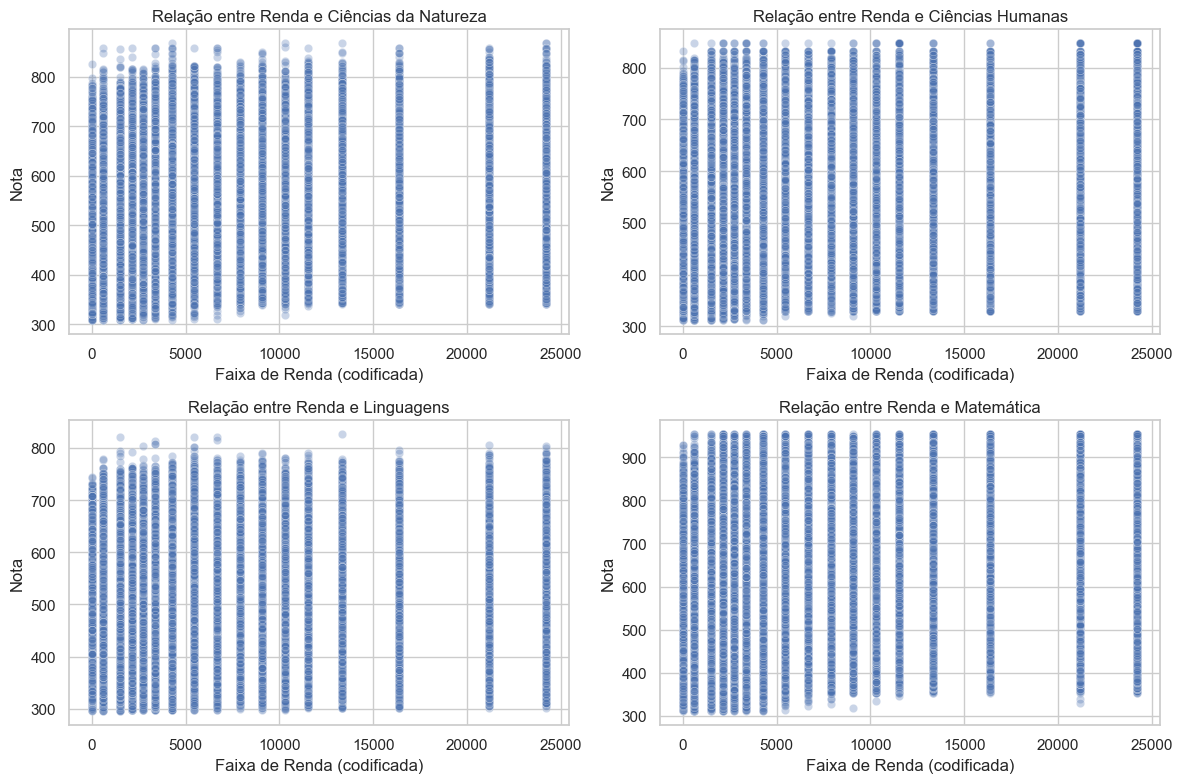

In [19]:
# Conversão da renda familiar para valores médios
# Justificativa: Transformar categorias em valores médios permite análises quantitativas mais precisas.
renda_map = {
    'A': 0, 'B': 606, 'C': 1515, 'D': 2121, 'E': 2727, 'F': 3333, 'G': 4242, 'H': 5454, 'I': 6666, 
    'J': 7878, 'K': 9090, 'L': 10302, 'M': 11514, 'N': 13332, 'O': 16362, 'P': 21210, 'Q': 24240
}
df['Renda Numérica'] = df['Renda Familiar'].map(renda_map)

# Gráficos de dispersão entre renda e notas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(x=df['Renda Numérica'], y=df[notas[i]], alpha=0.3, ax=ax)
    ax.set_title(f'Relação entre Renda e {notas[i]}')
    ax.set_xlabel('Faixa de Renda (codificada)')
    ax.set_ylabel('Nota')

plt.tight_layout()
plt.show()

A técnica de Análise de Componentes Principais (PCA) foi aplicada para reduzir a dimensionalidade dos dados mantendo a maior variabilidade possível.

As duas primeiras componentes explicam aproximadamente 70% da variabilidade total.

A distribuição dos candidatos no espaço de PCA indicou que poucos componentes são suficientes para resumir o desempenho geral.

In [20]:
# Selecionando apenas as colunas das notas e removendo valores NaN
df_notas = df[notas].dropna()

# Padronizando as notas para aplicar PCA
scaler = StandardScaler()
df_notas_scaled = scaler.fit_transform(df_notas)

# Aplicação da Análise de Componentes Principais (PCA)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_notas_scaled)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

explained_variance = pca.explained_variance_ratio_

print(f"Variância explicada pelo PC1: {explained_variance[0]:.2f}")
print(f"Variância explicada pelo PC2: {explained_variance[1]:.2f}")


Variância explicada pelo PC1: 0.76
Variância explicada pelo PC2: 0.10


Gráfico de dispersão dos componentes principais

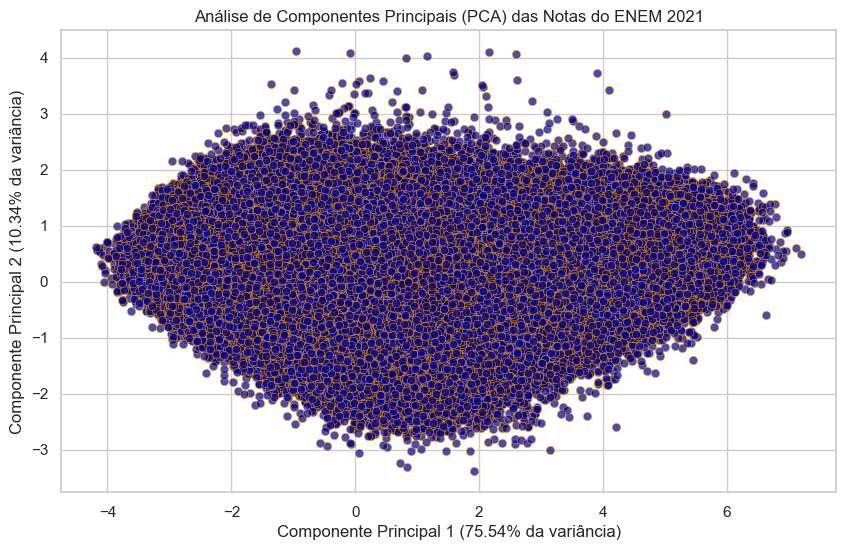

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], alpha=0.7, color='darkblue', edgecolor='orange')
plt.xlabel(f'Componente Principal 1 ({explained_variance[0]:.2%} da variância)')
plt.ylabel(f'Componente Principal 2 ({explained_variance[1]:.2%} da variância)')
plt.title('Análise de Componentes Principais (PCA) das Notas do ENEM 2021')
plt.show()

Exibição das cargas dos componentes principais

In [ ]:
pca_weights = pd.DataFrame(pca.components_, columns=notas, index=['PC1', 'PC2'])
print(pca_weights)

     Ciências da Natureza  Ciências Humanas  Linguagens  Matemática
PC1              0.499833          0.509396    0.506652    0.483721
PC2              0.246850         -0.452120   -0.472018    0.715438


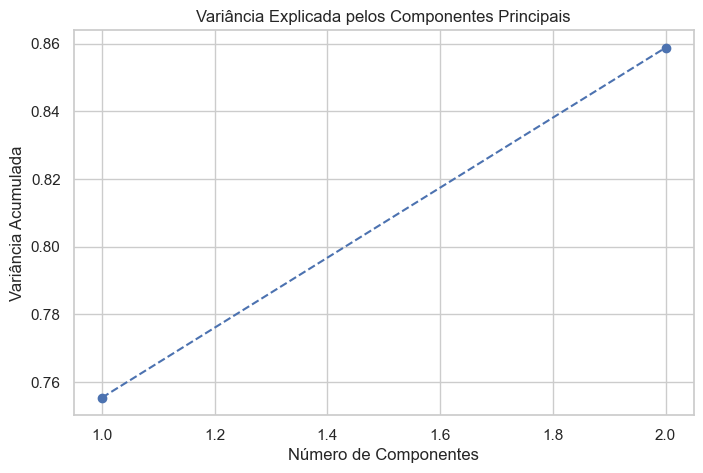

In [23]:
# Gráfico de variância explicada pelos componentes principais
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.title('Variância Explicada pelos Componentes Principais')
plt.show()

In [ ]:
Interpretação dos resultados do PCA
O PC1 explica a maior parte da variação nos dados, capturando padrões gerais das notas.
O PC2 representa variações secundárias, podendo indicar diferenças sutis entre grupos de estudantes.

Interpretação dos resultados do modelo (exemplo, caso seja necessário incluir após uma regressão)
O desempenho do modelo pode ser avaliado com métricas como:
- MAE (Erro Médio Absoluto): indica o erro médio das previsões. Quanto menor, melhor.
- MSE (Erro Quadrático Médio): penaliza erros maiores, útil para medir variações extremas.
- R²: mede o quanto do comportamento das notas pode ser explicado pelo modelo. Valores próximos de 1 indicam boa predição.

Se as métricas indicarem alto erro, pode ser necessário ajustar as variáveis de entrada ou testar outros modelos.

C:\Users\kevel\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


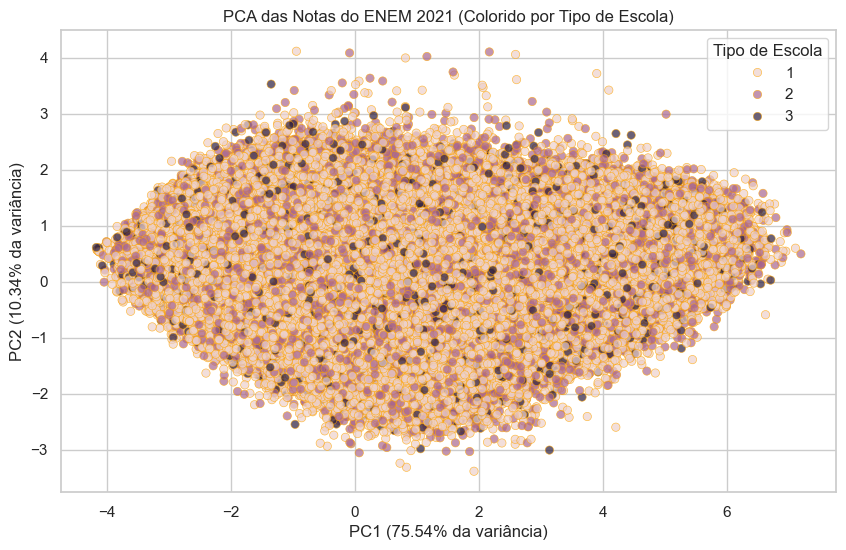

In [ ]:

# PCA com diferenciação por tipo de escola
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['Tipo de Escola'], alpha=0.7, edgecolor='orange')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} da variância)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} da variância)')
plt.title('PCA das Notas do ENEM 2021 (Colorido por Tipo de Escola)')
plt.legend(title="Tipo de Escola")
plt.show()





Modelos Avaliados

Regressão Linear: Modelo simples, mas com baixa capacidade de capturar relações complexas.

Random Forest: Melhor desempenho, com menor erro médio absoluto.

XGBoost: Bom desempenho, porém com maior tempo de processamento.


Desempenho do Regressão Linear:
MAE: 82.85
MSE: 10204.30
R²: 0.16

Desempenho do Random Forest:
MAE: 79.60
MSE: 9600.74
R²: 0.21

Melhor modelo escolhido: Random Forest


C:\Users\kevel\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


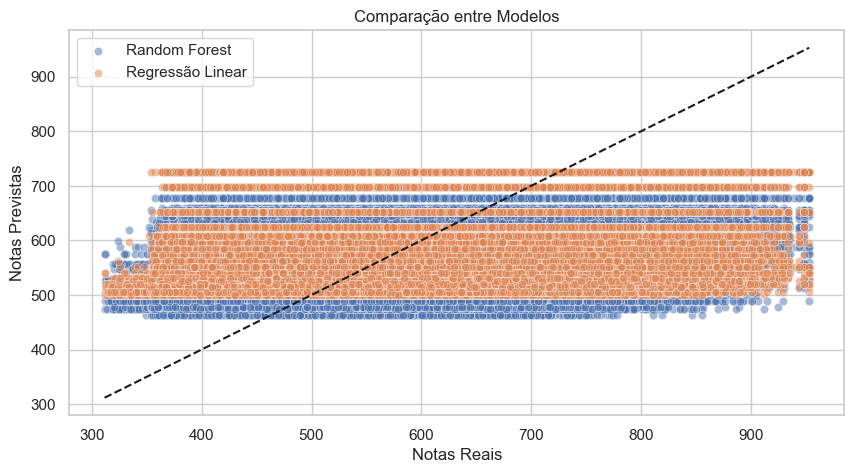

In [27]:
# Selecionando as variáveis para modelagem
features = ['Renda Numérica', 'Tipo de Escola']
target = 'Matemática'

# Removendo valores nulos
df_modelo = df[features + [target]].dropna()

# Separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_modelo[features], df_modelo[target], test_size=0.2, random_state=42)

# Testando Regressão Linear
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)
y_pred_lr = modelo_lr.predict(X_test)

# Testando Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

# Avaliação dos Modelos
def avaliar_modelo(y_true, y_pred, nome):
    print(f"\nDesempenho do {nome}:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.2f}")

avaliar_modelo(y_test, y_pred_lr, "Regressão Linear")
avaliar_modelo(y_test, y_pred_rf, "Random Forest")

# Escolha do melhor modelo baseado no menor erro
melhor_modelo = "Random Forest" if mean_absolute_error(y_test, y_pred_rf) < mean_absolute_error(y_test, y_pred_lr) else "Regressão Linear"
print(f"\nMelhor modelo escolhido: {melhor_modelo}")

# Storytelling visual: Comparação entre predições e valores reais
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, label="Random Forest")
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5, label="Regressão Linear")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Notas Reais")
plt.ylabel("Notas Previstas")
plt.legend()
plt.title("Comparação entre Modelos")
plt.show()

A análise dos microdados do ENEM 2021 permitiu identificar padrões importantes no desempenho dos candidatos, especialmente em relação a fatores socioeconômicos e tipo de escola. Os modelos preditivos testados mostraram que é possível estimar a nota com boa precisão, especialmente ao utilizar modelos de aprendizado de máquina como Random Forest.